# Task 1: Setting the Baseline 
## Task 1.1 Data Preparation and Validation Pipeline

In [7]:
import pandas as pd 
import numpy as np

df_raw_train = pd.read_csv("./kaggle/input/3bodyproblem/mlNOVA/mlNOVA/X_train.csv")
df_raw_test = pd.read_csv("./kaggle/input/3bodyproblem/mlNOVA/mlNOVA/X_test.csv")

### Visualize few trajectories

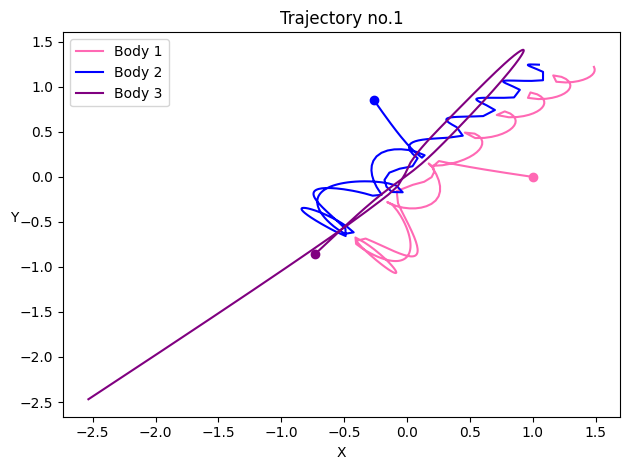

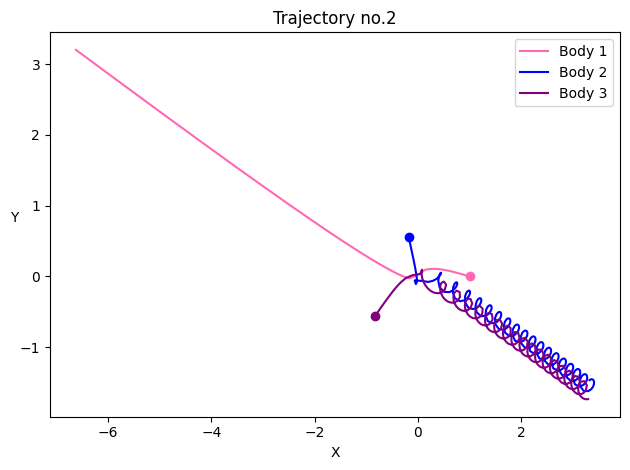

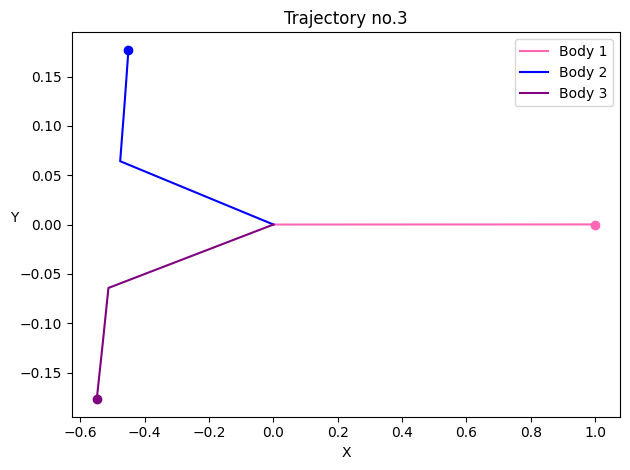

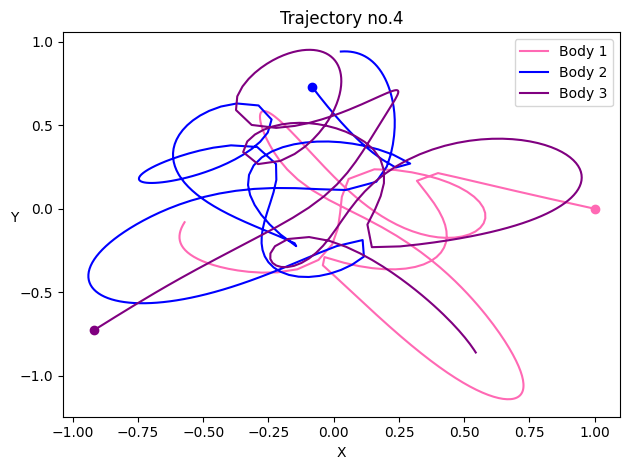

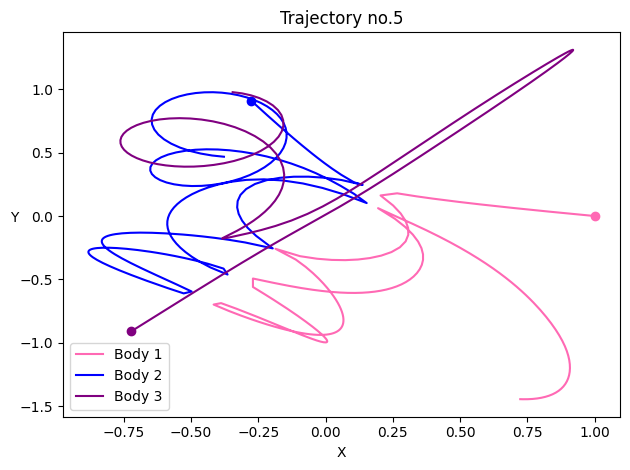

In [6]:
import matplotlib.pyplot as plt

start = 0
end = 257

for i in range(5):
    trajectory = df_raw_train[start:end]
    x1, y1, x2, y2, x3, y3 = trajectory.x_1, trajectory.y_1, trajectory.x_2, trajectory.y_2, trajectory.x_3, trajectory.y_3
    plt.plot(x1, y1, color="hotpink", label = "Body 1")
    plt.plot(x2, y2, color="blue", label = "Body 2")
    plt.plot(x3, y3, color="purple", label = "Body 3")
    plt.scatter(x1[start], y1[start], color="hotpink")
    plt.scatter(x2[start], y2[start], color="blue")
    plt.scatter(x3[start], y3[start], color="purple")
    plt.xlabel("X")
    plt.ylabel("Y", rotation=0)
    plt.title("Trajectory no." + str(i+1))
    plt.legend()
    plt.tight_layout()
    plt.show()

    start += 257
    end += 257


### Prepare the dataset

In [9]:
df_raw_train["group"] = df_raw_train["Id"]//257

In [10]:
#All starting positions
df_init = df_raw_train[ df_raw_train.index%257 == 0]

In [11]:
df_combined = df_raw_train.merge(df_init, on="group",  suffixes=('', '_init'))

# Step 1: Create a list/array of unique group_ids
unique_groups = df_combined['Id_init'].unique()

# Step 2: Create a random mask for this list
mask_train_test = np.random.rand(len(unique_groups)) < 0.8  # random True/False values

# Step 3: Split unique groups into two sets
group_train = unique_groups[mask_train_test]  # groups for the training set
group_testing = unique_groups[~mask_train_test]  # groups for the test set

# Step 4: Use the mask to split the DataFrame
train_set = df_combined[df_combined['Id_init'].isin(group_train)]
testing_set = df_combined[df_combined['Id_init'].isin(group_testing)]


unique_groups1 = testing_set['Id_init'].unique()

mask_val_test = np.random.rand(len(unique_groups1)) < 0.5

group_validation = unique_groups1[mask_val_test]  # groups for the training set
group_test = unique_groups1[~mask_val_test]  # groups for the test set

validation_set = testing_set[testing_set['Id_init'].isin(group_validation)]
test_set = testing_set[testing_set['Id_init'].isin(group_test)]



In [12]:
train_set

,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3,Id,group,t_init,x_1_init,y_1_init,v_x_1_init,v_y_1_init,x_2_init,y_2_init,v_x_2_init,v_y_2_init,x_3_init,y_3_init,v_x_3_init,v_y_3_init,Id_init
0,0.000000,1.000000,0.000000,0.000000,0.000000,-0.266467,0.859196,0.000000,0.000000,-0.733533,-0.859196,0.000000,0.000000,0,0,0.0,1.0,0.0,0.0,0.0,-0.266467,0.859196,0.0,0.0,-0.733533,-0.859196,0.0,0.0,0
1,0.039062,0.999548,0.000092,-0.023159,0.004731,-0.266261,0.858781,0.010574,-0.021257,-0.733287,-0.858874,0.012584,0.016526,1,0,0.0,1.0,0.0,0.0,0.0,-0.266467,0.859196,0.0,0.0,-0.733533,-0.859196,0.0,0.0,0
2,0.078125,0.998190,0.000370,-0.046362,0.009474,-0.265641,0.857535,0.021172,-0.042552,-0.732549,-0.857905,0.025189,0.033078,2,0,0.0,1.0,0.0,0.0,0.0,-0.266467,0.859196,0.0,0.0,-0.733533,-0.859196,0.0,0.0,0
3,0.117188,0.995925,0.000833,-0.069654,0.014239,-0.264606,0.855456,0.031817,-0.063924,-0.731318,-0.856289,0.037837,0.049685,3,0,0.0,1.0,0.0,0.0,0.0,-0.266467,0.859196,0.0,0.0,-0.733533,-0.859196,0.0,0.0,0
4,0.156250,0.992747,0.001483,-0.093080,0.019040,-0.263154,0.852540,0.042533,-0.085412,-0.729592,-0.854022,0.050548,0.066372,4,0,0.0,1.0,0.0,0.0,0.0,-0.266467,0.859196,0.0,0.0,-0.733533,-0.859196,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1284995,9.843750,-0.022787,-0.354678,-1.450539,-0.511101,-0.128897,-0.618452,1.066492,-0.497032,0.151684,0.973131,0.384048,1.008133,1284995,4999,0.0,1.0,0.0,0.0,0.0,-0.300429,0.400142,0.0,0.0,-0.699571,-0.400142,0.0,0.0,1284743
1284996,9.882810,-0.082072,-0.384254,-1.556362,-1.038875,-0.084507,-0.627569,1.177829,0.065469,0.166578,1.011822,0.378533,0.973406,1284996,4999,0.0,1.0,0.0,0.0,0.0,-0.300429,0.400142,0.0,0.0,-0.699571,-0.400142,0.0,0.0,1284743
1284997,9.921880,-0.140434,-0.438907,-1.348462,-1.794786,-0.040823,-0.610311,0.975436,0.853069,0.181257,1.049218,0.373027,0.941717,1284997,4999,0.0,1.0,0.0,0.0,0.0,-0.300429,0.400142,0.0,0.0,-0.699571,-0.400142,0.0,0.0,1284743
1284998,9.960940,-0.177344,-0.524277,-0.380080,-2.492241,-0.018380,-0.561151,0.012292,1.579595,0.195724,1.085428,0.367788,0.912645,1284998,4999,0.0,1.0,0.0,0.0,0.0,-0.300429,0.400142,0.0,0.0,-0.699571,-0.400142,0.0,0.0,1284743


In [13]:
validation_set

,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3,Id,group,t_init,x_1_init,y_1_init,v_x_1_init,v_y_1_init,x_2_init,y_2_init,v_x_2_init,v_y_2_init,x_3_init,y_3_init,v_x_3_init,v_y_3_init,Id_init
5140,0.000000,1.000000,0.000000,0.000000,0.000000,-0.094372,0.373004,0.000000,0.000000,-0.905628,-0.373004,0.000000,0.000000,5140,20,0.0,1.0,0.0,0.0,0.0,-0.094372,0.373004,0.0,0.0,-0.905628,-0.373004,0.0,0.0,5140
5141,0.039062,0.999261,0.000145,-0.037848,0.007438,-0.094294,0.372395,0.003985,-0.031210,-0.904967,-0.372540,0.033863,0.023771,5141,20,0.0,1.0,0.0,0.0,0.0,-0.094372,0.373004,0.0,0.0,-0.905628,-0.373004,0.0,0.0,5140
5142,0.078125,0.997041,0.000581,-0.075832,0.014882,-0.094061,0.370565,0.007960,-0.062505,-0.902981,-0.371146,0.067872,0.047623,5142,20,0.0,1.0,0.0,0.0,0.0,-0.094372,0.373004,0.0,0.0,-0.905628,-0.373004,0.0,0.0,5140
5143,0.117188,0.993333,0.001308,-0.114089,0.022339,-0.093672,0.367509,0.011913,-0.093975,-0.899661,-0.368818,0.102176,0.071636,5143,20,0.0,1.0,0.0,0.0,0.0,-0.094372,0.373004,0.0,0.0,-0.905628,-0.373004,0.0,0.0,5140
5144,0.156250,0.988123,0.002327,-0.152762,0.029812,-0.093130,0.363220,0.015831,-0.125707,-0.894992,-0.365546,0.136931,0.095895,5144,20,0.0,1.0,0.0,0.0,0.0,-0.094372,0.373004,0.0,0.0,-0.905628,-0.373004,0.0,0.0,5140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1284481,9.843750,-0.932575,-2.334208,0.656761,-2.165135,-1.022670,-2.212383,-0.735155,1.948568,1.955245,4.546591,0.078393,0.216566,1284481,4997,0.0,1.0,0.0,0.0,0.0,-0.112039,0.505901,0.0,0.0,-0.887961,-0.505901,0.0,0.0,1284229
1284482,9.882810,-0.918159,-2.401290,0.194456,-1.405421,-1.040137,-2.153735,-0.272290,1.190154,1.958296,4.555025,0.077834,0.215267,1284482,4997,0.0,1.0,0.0,0.0,0.0,-0.112039,0.505901,0.0,0.0,-0.887961,-0.505901,0.0,0.0,1284229
1284483,9.921880,-0.913998,-2.448691,0.037030,-1.050570,-1.047328,-2.114718,-0.114306,0.836599,1.961326,4.563409,0.077276,0.213971,1284483,4997,0.0,1.0,0.0,0.0,0.0,-0.112039,0.505901,0.0,0.0,-0.887961,-0.505901,0.0,0.0,1284229
1284484,9.960940,-0.914413,-2.484791,-0.051593,-0.809496,-1.049921,-2.086951,-0.025127,0.596815,1.964333,4.571742,0.076720,0.212680,1284484,4997,0.0,1.0,0.0,0.0,0.0,-0.112039,0.505901,0.0,0.0,-0.887961,-0.505901,0.0,0.0,1284229


In [14]:
test_set

,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3,Id,group,t_init,x_1_init,y_1_init,v_x_1_init,v_y_1_init,x_2_init,y_2_init,v_x_2_init,v_y_2_init,x_3_init,y_3_init,v_x_3_init,v_y_3_init,Id_init
771,0.000000,1.000000,0.000000,0.000000,0.000000,-0.081487,0.726750,0.000000,0.000000,-0.918513,-0.726750,0.000000,0.000000,771,3,0.0,1.0,0.0,0.0,0.0,-0.081487,0.726750,0.0,0.0,-0.918513,-0.726750,0.0,0.0,771
772,0.039062,0.999457,0.000186,-0.027789,0.009550,-0.081250,0.726264,0.012175,-0.024874,-0.918208,-0.726450,0.015613,0.015324,772,3,0.0,1.0,0.0,0.0,0.0,-0.081487,0.726750,0.0,0.0,-0.918513,-0.726750,0.0,0.0,771
773,0.078125,0.997828,0.000746,-0.055653,0.019130,-0.080536,0.724806,0.024396,-0.049803,-0.917292,-0.725552,0.031257,0.030674,773,3,0.0,1.0,0.0,0.0,0.0,-0.081487,0.726750,0.0,0.0,-0.918513,-0.726750,0.0,0.0,771
774,0.117188,0.995107,0.001682,-0.083671,0.028770,-0.079342,0.722372,0.036711,-0.074842,-0.915765,-0.724053,0.046961,0.046072,774,3,0.0,1.0,0.0,0.0,0.0,-0.081487,0.726750,0.0,0.0,-0.918513,-0.726750,0.0,0.0,771
775,0.156250,0.991288,0.002995,-0.111923,0.038501,-0.077666,0.718956,0.049166,-0.100048,-0.913622,-0.721952,0.062756,0.061546,775,3,0.0,1.0,0.0,0.0,0.0,-0.081487,0.726750,0.0,0.0,-0.918513,-0.726750,0.0,0.0,771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1281654,9.843750,-1.461081,0.670221,0.993174,-0.021191,-1.542492,0.408971,-1.545438,0.144521,3.003573,-1.079192,0.552264,-0.123330,1281654,4986,0.0,1.0,0.0,0.0,0.0,-0.472486,0.523105,0.0,0.0,-0.527514,-0.523105,0.0,0.0,1281402
1281655,9.882810,-1.426125,0.660538,0.778060,-0.452679,-1.598959,0.423450,-1.327142,0.574866,3.025084,-1.083988,0.549082,-0.122187,1281655,4986,0.0,1.0,0.0,0.0,0.0,-0.472486,0.523105,0.0,0.0,-0.527514,-0.523105,0.0,0.0,1281402
1281656,9.921880,-1.401405,0.636448,0.476549,-0.761695,-1.645066,0.452290,-1.022489,0.882754,3.046471,-1.088738,0.545940,-0.121059,1281656,4986,0.0,1.0,0.0,0.0,0.0,-0.472486,0.523105,0.0,0.0,-0.527514,-0.523105,0.0,0.0,1281402
1281657,9.960940,-1.389609,0.602442,0.119612,-0.961876,-1.678126,0.491003,-0.662448,1.081823,3.067736,-1.093446,0.542837,-0.119947,1281657,4986,0.0,1.0,0.0,0.0,0.0,-0.472486,0.523105,0.0,0.0,-0.527514,-0.523105,0.0,0.0,1281402


### Verify dataset splitting

In [15]:
# Get sorted unique Id_init values
unique_sorted_ids_train = sorted(set(train_set['Id_init'].values))
unique_sorted_ids_val = sorted(set(validation_set['Id_init'].values))
unique_sorted_ids_test = sorted(set(test_set['Id_init'].values))

# Find intersection of the two sets
intersection_ids1 = sorted(set(unique_sorted_ids_train) & set(unique_sorted_ids_val))
intersection_ids2 = sorted(set(unique_sorted_ids_train) & set(unique_sorted_ids_test))
intersection_ids3 = sorted(set(unique_sorted_ids_test) & set(unique_sorted_ids_val))

# Display the results]
print("Intersection of IDs:", intersection_ids1)
print("Intersection of IDs:", intersection_ids2)
print("Intersection of IDs:", intersection_ids3)

Intersection of IDs: []
Intersection of IDs: []
Intersection of IDs: []


In [16]:
input_train = train_set[["t","x_1_init", "y_1_init", "x_2_init", "y_2_init", "x_3_init", "y_3_init"]]
input_validation = validation_set[["t","x_1_init", "y_1_init", "x_2_init", "y_2_init", "x_3_init", "y_3_init"]]

input_train.head()

,t,x_1_init,y_1_init,x_2_init,y_2_init,x_3_init,y_3_init
0,0.000000,1.0,0.0,-0.266467,0.859196,-0.733533,-0.859196
1,0.039062,1.0,0.0,-0.266467,0.859196,-0.733533,-0.859196
2,0.078125,1.0,0.0,-0.266467,0.859196,-0.733533,-0.859196
3,0.117188,1.0,0.0,-0.266467,0.859196,-0.733533,-0.859196
4,0.156250,1.0,0.0,-0.266467,0.859196,-0.733533,-0.859196


In [ ]:
input_validation.head()

In [17]:
output_train = train_set[["x_1", "y_1", "x_2", "y_2", "x_3", "y_3"]]
output_validation = validation_set[["x_1", "y_1", "x_2", "y_2", "x_3", "y_3"]]

output_train.head()

,x_1,y_1,x_2,y_2,x_3,y_3
0,1.000000,0.000000,-0.266467,0.859196,-0.733533,-0.859196
1,0.999548,0.000092,-0.266261,0.858781,-0.733287,-0.858874
2,0.998190,0.000370,-0.265641,0.857535,-0.732549,-0.857905
3,0.995925,0.000833,-0.264606,0.855456,-0.731318,-0.856289
4,0.992747,0.001483,-0.263154,0.852540,-0.729592,-0.854022
...,...,...,...,...,...,...
1284995,-0.022787,-0.354678,-0.128897,-0.618452,0.151684,0.973131
1284996,-0.082072,-0.384254,-0.084507,-0.627569,0.166578,1.011822
1284997,-0.140434,-0.438907,-0.040823,-0.610311,0.181257,1.049218
1284998,-0.177344,-0.524277,-0.018380,-0.561151,0.195724,1.085428


In [ ]:
output_validation.head()


In [18]:
groups = train_set["group"]
groups

0             0
1             0
2             0
3             0
4             0
           ... 
1284995    4999
1284996    4999
1284997    4999
1284998    4999
1284999    4999
Name: group, Length: 1023374, dtype: int64

## Task 1.2 Learn the baseline model

In [17]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

nn = MLPRegressor(random_state=1, max_iter=3)
svm = SVR(kernel="linear")
model = LinearRegression()
modelRidge = Ridge()
modelLasso = Lasso()

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipe = Pipeline(
    [
            ('scaling', StandardScaler()), 
            ("model", modelRidge)
    ])
pipe

Pipeline(steps=[('scaling', StandardScaler()), ('model', Ridge())])

In [19]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupKFold

    
pipe.fit(input_train, output_train)
y_hat = pipe.predict(input_validation)
mse = mean_squared_error(output_validation, y_hat, squared = False)

print("MSE: ", mse)

Fold
Fold
Fold
Fold
Fold
[1.2501240036519852, 1.4105111249413982, 1.2034770547793794, 1.2607783384607314, 1.2243580250077644]
AVG: 1.2698497093682517


In [20]:
import numpy as np

def plot_y_yhat(y_validation, y_pred, plot_title = "plot"):
    labels = ['x_1','y_1','x_2','y_2','x_3','y_3']
    MAX = 500
    if len(y_validation) > MAX:
        idx = np.random.choice(len(y_validation),MAX, replace=False)
    else:
        idx = np.arange(len(y_validation))
    plt.figure(figsize=(10,10))
    for i in range(6):
        x0 = np.min(y_validation[idx,i])
        x1 = np.max(y_validation[idx,i])
        plt.subplot(3,2,i+1)
        plt.scatter(y_validation[idx,i],y_pred[idx,i])
        plt.xlabel('True '+labels[i])
        plt.ylabel('Predicted '+labels[i])
        plt.plot([x0,x1],[x0,x1],color='red')
        plt.axis('square')
    plt.savefig(plot_title+'.pdf')
    plt.show()

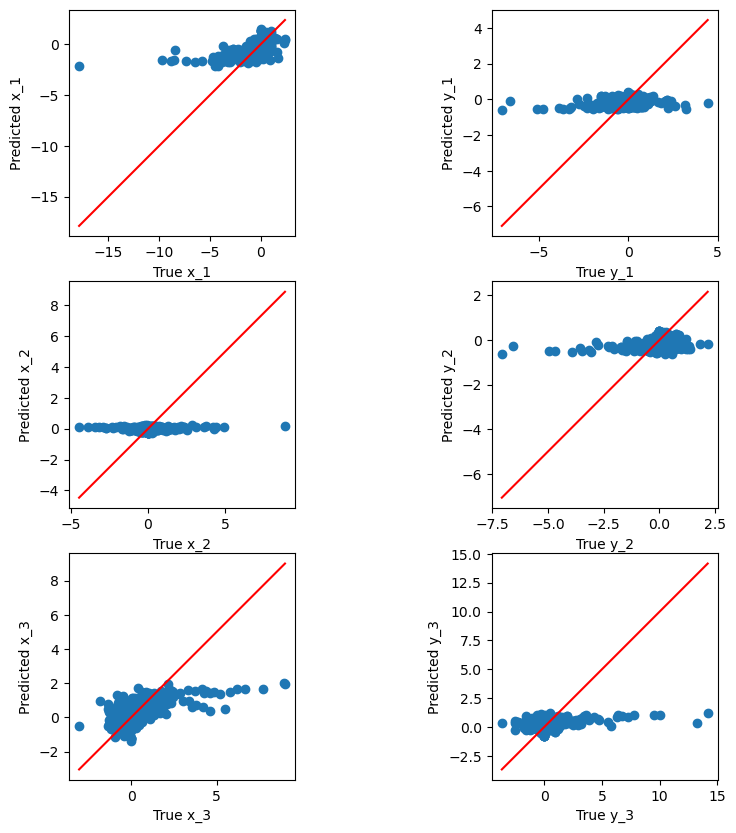

In [21]:
plot_y_yhat(output_validation.to_numpy(), pd.DataFrame(y_hat).to_numpy())


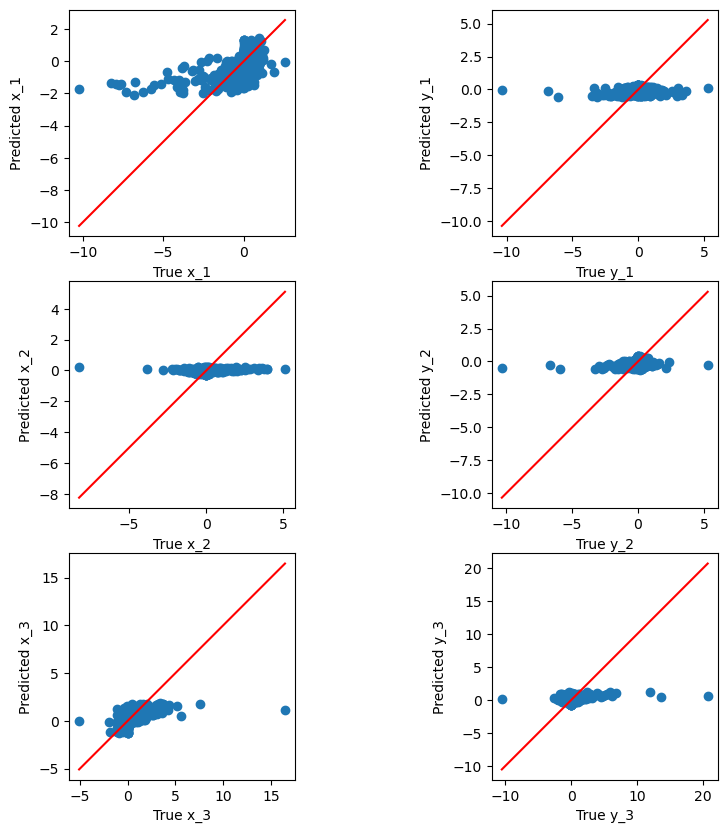

In [22]:
plot_y_yhat(output_validation.to_numpy(), pd.DataFrame(y_hat).to_numpy())

# Task 2: Nonlinear models on the data — the Polynomial Regression model
## Task 2.1 Development

In [23]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error

def validate_poly_regression(X_train, y_train, X_val, y_val, regressor=None, degrees=range(1,10), max_features=None):
    
    best_rsme = 1000
    best_degree = 0
    train_scores = []
    validation_scores = []
    n_features_list = []

    for d in degrees:
        print("Degree ", d)

        pipe_d_degree= Pipeline(
    [       ('preprocessor', PolynomialFeatures(degree=d)),
            ('model', RidgeCV(alphas=np.logspace(-6, 6, 13)))
    ])

        pipe_d_degree.fit(X_train, y_train)

        n_features = pipe_d_degree.named_steps['preprocessor'].n_output_features_
        n_features_list.append(n_features)

        y_train_predict = pipe_d_degree.predict(X_train)
        y_val_predict = pipe_d_degree.predict(X_val)

        #print("Degree:", d) 

        train_error = np.sqrt(mean_squared_error(y_train, y_train_predict))
        #print("Train MSE:", train_error)

        val_error = np.sqrt(mean_squared_error(y_val, y_val_predict))
        #print("Test MSE:", test_error)

        if val_error < best_rsme:
            best_rsme = val_error
            best_degree = d

        train_scores.append(train_error)
        validation_scores.append(val_error)

        print("Val error: ", val_error)

    return train_scores, validation_scores, best_rsme, best_degree, n_features_list

In [ ]:
#input_train=input_train[0:6425]
#output_train=output_train[0:6425]
#groups=groups[0:6425]


sample_train_set = train_set.sample(frac=0.01)
sample_input_train = sample_train_set[["t","x_1_init", "y_1_init", "x_2_init", "y_2_init", "x_3_init", "y_3_init"]]
sample_output_train = sample_train_set[["x_1", "y_1", "x_2", "y_2", "x_3", "y_3"]]

In [ ]:
degrees=range(1,10)
degree_scores = {d: {'train_scores': [], 'test_scores': []} for d in degrees}
best_rsmes = []
best_degrees = []

for _ in range(10):
    train_scores, validation_scores, best_rsme, best_degree, n_features_list = validate_poly_regression(sample_input_train, sample_output_train, input_validation, output_validation)

    best_rsmes.append(best_rsme)
    best_degrees.append(best_degree)

    for d in degrees:
        degree_scores[d]['train_scores'].append(train_scores[d-1])
        degree_scores[d]['test_scores'].append(validation_scores[d-1])

In [ ]:
best_degree_ever = max(set(best_degrees), key=best_degrees.count)

pipe_best_degree= Pipeline(
[       ('preprocessor', PolynomialFeatures(degree=best_degree_ever)),
        ('model', RidgeCV(alphas=np.logspace(-6, 6, 13)))
])

pipe_best_degree.fit(input_train, output_train)

output_train_predict = pipe_best_degree.predict(input_train)
output_val_predict = pipe_best_degree.predict(input_validation)

train_error = np.sqrt(mean_squared_error(output_train, output_train_predict))
print("Train MSE:", train_error)

val_error = np.sqrt(mean_squared_error(output_validation, output_val_predict))
print("Validation MSE:", train_error)

## Task 2.2 Evaluation

# Task 3: Feature Engineering
## Task 3.1 Removing variables

## Task 3.2 Evaluation of Variable Reduction

## Task 3.3 Adding Variables

## Task 3.4 Evaluation of Variable Augmentation

# Task 4: Nonparamentric Model — the k-Nearest Neighbors Regressor
## Task 4.1 Development

In [19]:
    
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

modelKnn = KNeighborsRegressor()

pipe = Pipeline(
    [
            ('scaling', StandardScaler()), 
            ("model", modelKnn)
    ])
pipe
    

Pipeline(steps=[('scaling', StandardScaler()),
                ('model', KNeighborsRegressor())])

In [20]:

pipe.fit(input_train, output_train)
y_hat = pipe.predict(input_validation)
rmse_list.append(mean_squared_error(output_validation, y_hat, squared = False))

print(rmse_list)
print("AVG:", sum(rmse_list)/len(rmse_list))


#def validate_knn_regression(X_train, y_train, X_val, y_val, k=range(1,15)):


NameError: name 'X_validation' is not defined

## Task 4.2 Evaluation

# Task 5 [Optional]